# Fiddler Guardrails Free Trial Quick Start Guide

Fiddler Guardrails provides enterprise-grade protection against critical LLM risks in production environments. This solution actively moderates and mitigates harmful content in both prompts and responses, including hallucinations, toxicity ,safety violations, prompt injection attacks, and jailbreaking attempts. The solution is powered by proprietary, fine-tuned, task-specific Fiddler Trust Models, specifically engineered for real-time content analysis.


## Free Trial Offer
* [Sign Up for an API Key](https://docs.fiddler.ai/tutorials-and-quick-starts/fiddler-guardrails-free-trial/guardrails-quick-start-guide) (needed to run this notebook)
* [Free Trial Documentation](https://docs.fiddler.ai/technical-reference/fiddler-guardrails-free-trial-documentation)
* [Guardrails FAQ](https://docs.fiddler.ai/tutorials-and-quick-starts/fiddler-guardrails-free-trial/guardrails-faq)

## Notebook Summary

In this notebook we load a subset of RAGTruth Q&A tasks, a hallucination corpus within a RAG setting. We send these examples to the FTL Response Faithfulness Guardrail. We report on classification metrics and latency.

This notebook should complete within 1 minute.

In [1]:
%pip install -q matplotlib numpy pandas requests scikit-learn

import time
from typing import Tuple


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
plt.style.use("ggplot")


In [ ]:
FIDDLER_GUARDRAILS_TOKEN = ""

GUARDRAILS_BASE_URL = "https://guardrails.cloud.fiddler.ai/v3/guardrails"

FAITHFULNESS_GUARDRAILS_URL = f"{GUARDRAILS_BASE_URL}/ftl-response-faithfulness"

GUARDRAILS_HEADERS = {
    "Authorization": f"Bearer {FIDDLER_GUARDRAILS_TOKEN}",
    "Content-Type": "application/json",
}

assert FIDDLER_GUARDRAILS_TOKEN != "", (
    "Set :FIDDLER_GUARDRAILS_TOKEN above; sign-up at https://docs.fiddler.ai/tutorials-and-quick-starts/fiddler-guardrails-free-trial/guardrails-quick-start-guide"
)

## 1. Load RAGTruth QA Dataset

Download from GitHub and set columns we'll use for looking at performance

In [4]:
def read_ragtruth_qa_from_github(sample_size: int = None) -> pd.DataFrame:
    """Read RAGTruth from GitHub and filter to the Q&A examples in the test set.

    Args:
        sample_size (int, optional): How many records to return. If specified then a balanced sample will returned.
            Defaults to None, which means all records will be returned

    Returns:
        pd.DataFrame: RAGTruth dataset filtered to Q&A examples in the test set, optionally downsampled.
    """
    ragtruth_source_info = pd.read_json(
        "https://github.com/ParticleMedia/RAGTruth/raw/refs/heads/main/dataset/source_info.jsonl",
        lines=True,
    )
    ragtruth_response = pd.read_json(
        "https://github.com/ParticleMedia/RAGTruth/raw/refs/heads/main/dataset/response.jsonl",
        lines=True,
    )
    df = pd.merge(
        ragtruth_source_info,
        ragtruth_response,
        left_on="source_id",
        right_on="source_id",
    )
    df_qa = df[(df["task_type"] == "QA") & (df["split"] == "test")]

    if sample_size is None:
        return df_qa
    else:
        df_qa_pos = df_qa[df_qa["labels"].apply(len) == 0].sample(
            sample_size // 2, random_state=19
        )
        df_qa_neg = df_qa[df_qa["labels"].apply(len) != 0].sample(
            sample_size // 2, random_state=19
        )
        return pd.concat([df_qa_pos, df_qa_neg])


In [5]:
ragtruth_qa = read_ragtruth_qa_from_github(
    sample_size=20
)  # Note: the Free Trial is limited to 70 requests in 1 hour

##

In [6]:
ragtruth_qa["n_input_words"] = (
    ragtruth_qa["source_info"].astype(str).str.split().str.len()
    + ragtruth_qa["response"].astype(str).str.split().str.len()
)  # a rough estimate of word count

ragtruth_qa["is_faithful"] = (ragtruth_qa["labels"].apply(len) == 0).astype(int)
display(ragtruth_qa["is_faithful"].value_counts())

is_faithful
1    10
0    10
Name: count, dtype: int64

## 2. Helper Code for Guardrails and Evaluation Code


In [7]:
def get_faithfulness_response(
    context: str, response: str, sleep_seconds: float = 0.350
) -> Tuple[float, float]:
    """Invoke the guardrail for Faithfulness, returning the faithfulness score and latency time

    Args:
        context (str): Guardrails context field
        response (str): Guardrails response field

    Returns:
        Tuple[float, float]: Faithfulness score and latency in seconds.
    """
    time.sleep(sleep_seconds)
    data = {
        "context": context,
        "response": response,
    }
    try:
        response = requests.post(
            FAITHFULNESS_GUARDRAILS_URL,
            headers=GUARDRAILS_HEADERS,
            json={"data": data},
            timeout=30,
        )
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None, response.elapsed.total_seconds()

    return response.json()["fdl_faithful_score"], response.elapsed.total_seconds()

In [8]:
faithful_display_name_map = {0: "hallucination", 1: "faithful"}
pos_label = "faithful"

In [9]:
def plot_classification_results(df: pd.DataFrame, ds_name: str):
    global faithful_display_name_map, pos_label

    df_clean = df.dropna(subset=["fdl_faithful_score"])
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(ds_name)
    pr = PrecisionRecallDisplay.from_predictions(
        df_clean["is_faithful"].map(faithful_display_name_map),
        y_pred=df_clean["fdl_faithful_score"],
        ax=axes[2],
        pos_label=pos_label,
    )
    pr.ax_.set_title(f"Precision-Recall Curve")

    roc = RocCurveDisplay.from_predictions(
        df_clean["is_faithful"].map(faithful_display_name_map),
        y_pred=df_clean["fdl_faithful_score"],
        ax=axes[1],
        plot_chance_level=True,
        pos_label=pos_label,
    )
    roc.ax_.set_title(f"ROC Curve")

    axes[0].hist(
        df_clean[df_clean["is_faithful"] == 1]["fdl_faithful_score"],
        color="cornflowerblue",
        label="Faithful",
        bins=np.arange(0, 1.05, 0.1),
    )
    axes[0].hist(
        df_clean[df_clean["is_faithful"] == 0]["fdl_faithful_score"],
        color="orange",
        label="Hallucination",
        histtype="step",
        linewidth=1.5,
        bins=np.arange(0, 1.05, 0.1),
    )
    axes[0].set_xlabel("Score")
    axes[0].set_ylabel("Frequency", axes=axes[0])
    axes[0].set_title(f"Faithfulness Scores")
    axes[0].legend()
    return fig

In [10]:
def plot_latency(df: pd.DataFrame, ds_name: str):
    df_clean = df.dropna(subset=["fdl_faithful_score"])
    p95_latency = int(1000 * df_clean["fdl_faithful_latency"].quantile(0.95).round(3))
    p50_words_per_sec = int(
        (df_clean["n_input_words"] / df_clean["fdl_faithful_latency"]).median()
    )

    fig, ax = plt.subplots()
    fig.suptitle(f"{ds_name} Latency")

    ax.hist(df_clean["fdl_faithful_latency"])
    ax.set_title(f"p95={p95_latency}ms; median {p50_words_per_sec} words per second")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Frequency")

    return fig

## 3. Run Dataset Through Guardrails

We will sleep between requests to avoid rate-limit restrictions on the free trial.

In [11]:
ragtruth_qa[["fdl_faithful_score", "fdl_faithful_latency"]] = ragtruth_qa.apply(
    lambda row: get_faithfulness_response(str(row["source_info"]), row["response"]),
    axis=1,
    result_type="expand",
)

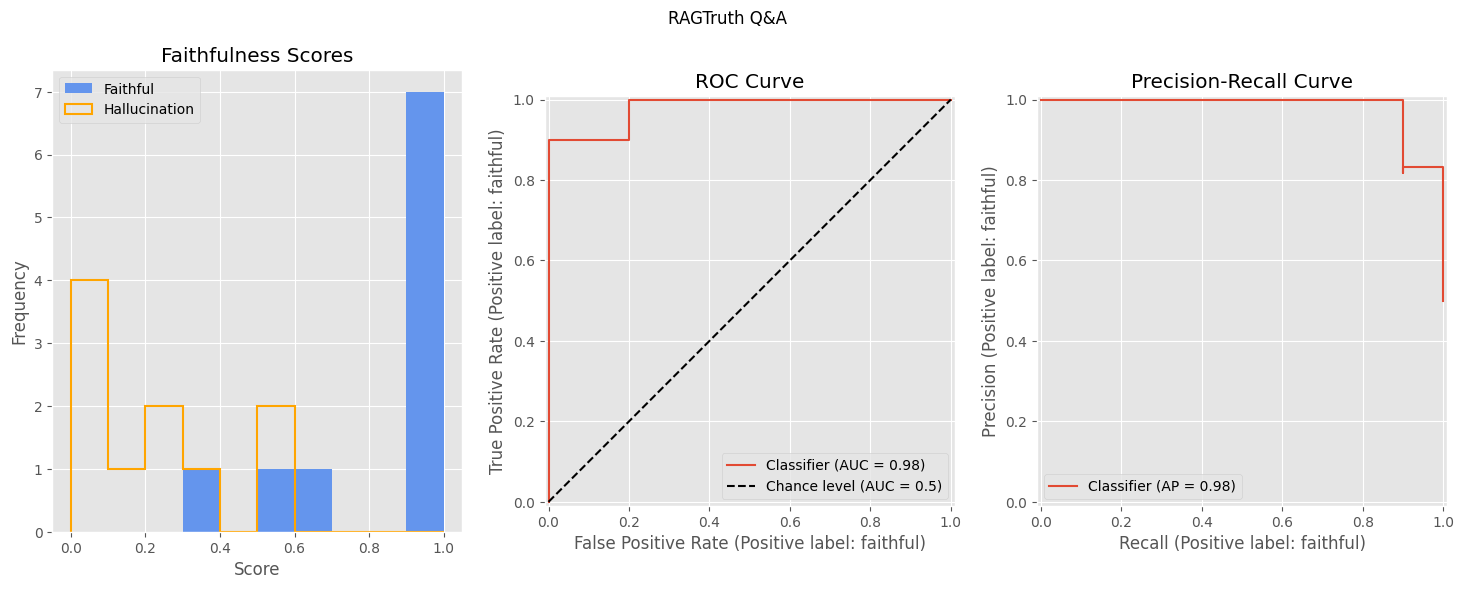

In [12]:
plt.show(plot_classification_results(ragtruth_qa, "RAGTruth Q&A"))

In [13]:
print(
    classification_report(
        ragtruth_qa["is_faithful"].map(faithful_display_name_map),
        (ragtruth_qa["fdl_faithful_score"] > 0.6)
        # This is a good default threshold but you can change to match your use-case
        .astype(int)
        .map(faithful_display_name_map),
    )
)

               precision    recall  f1-score   support

     faithful       1.00      0.80      0.89        10
hallucination       0.83      1.00      0.91        10

     accuracy                           0.90        20
    macro avg       0.92      0.90      0.90        20
 weighted avg       0.92      0.90      0.90        20



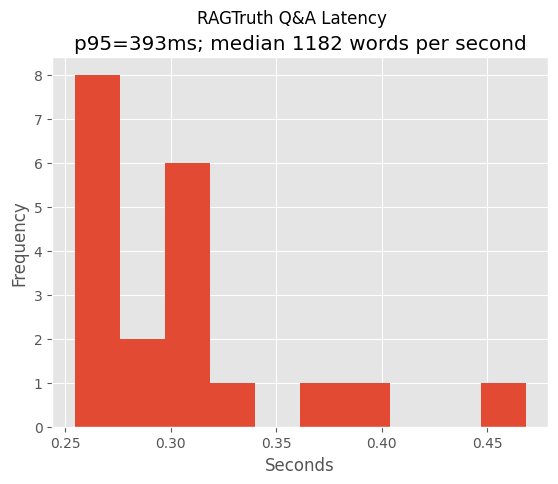

In [14]:
rag_latency_fig = plot_latency(ragtruth_qa, "RAGTruth Q&A")
plt.show()